In [17]:
import numpy as np 
import torch 
import ot 
import os

os.chdir('/home/baly/projects/PGW_Metric')
#from lib.gromov import partial_gromov_ver1, cost_matrix_d,gwgrad_partial1,partial_gromov_wasserstein
# import lib.gromov_test as test
import lib.gromov as gw
from lib.opt import *


import numpy as np 
import numba as nb
import warnings
import time
from ot.backend import get_backend, NumpyBackend
from ot.lp import emd
#import unbalanced GW 

from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure

In [18]:
#@nb.njit(fastmath=True)
def generate_d_square(d,n):
    x_list=[]
    for i in range(d):
        x = np.linspace(-1, 1, n)
        x_list.append(x)
    xx= np.meshgrid(*x_list,indexing='ij')
    data=np.zeros((n**d,d))
    for i in range(d):
        data[:,i]=xx[i].reshape(-1)
    return data


#@nb.njit(fastmath=True)
def generate_d_sphere(d,n,seed=20):
    np.random.seed(seed)
    N=n**d
    data=np.random.normal(size=(N,d))
    norm=np.sqrt(np.sum(np.square(data),1)).reshape(-1,1)
    data=data/norm
    return data

In [19]:
# Set up a solver for KL-(U)GW
# Set rho=float("Inf") to run balanced GW computation
eps = 1.0
rho, rho2 = 1.0, 1.0

# Generate two mm-spaces with euclidean metrics
a, dx, a1 = generate_measure(n_batch=1, n_sample=5, n_dim=3)
b, dy, a2 = generate_measure(n_batch=1, n_sample=6, n_dim=2)
# Reduce the first axis to keep one space (method generates batches)
a, b, dx, dy = a[0], b[0], dx[0], dy[0]

# Compute the bi-convex relaxation of the UGW problem
pi, gamma = exp_ugw_sinkhorn(a, dx, b, dy, init=None, eps=eps,
                             rho=rho, rho2=rho2,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)

# Compute the loss
cost = ugw_cost(pi, gamma, a, dx, b, dy, eps=eps, rho=rho, rho2=rho2)
print("Cost of the biconvex relaxation: ", cost)

Cost of the biconvex relaxation:  tensor(0.1609)


In [20]:
k=3
n2=k**3
n3=k**2

np.random.seed(4)
sq2=generate_d_square(d=2,n=n2)
sq3=generate_d_square(d=3,n=n3)+np.array([0,0,3])
sp2=generate_d_sphere(d=2,n=n2)+np.array([7,0])
sp3=generate_d_sphere(d=3,n=n3)+np.array([7,0,0])+np.array([0,0,3])

p_sq2=np.ones(sq2.shape[0])/sq2.shape[0]
p_sq3=np.ones(sq3.shape[0])/sq3.shape[0]
p_sp2=np.ones(sp2.shape[0])/sp2.shape[0]
p_sp3=np.ones(sp3.shape[0])/sp3.shape[0]

X=np.concatenate((sq2,sp2))
Y=np.concatenate((sq3,sp3))
p=np.concatenate((0.3*p_sq2,0.7*p_sp2))
q=np.concatenate((0.5*p_sq3,0.5*p_sq3))

C1=cost_matrix_d(X,X)
C2=cost_matrix_d(Y,Y)
n=X.shape[0]
print(X.shape[0])
print(Y.shape[0])

1458
1458


In [21]:
# without prior knowledge 

time1=time.time()
gamma1=ot.gromov.gromov_wasserstein(C1,C2,p,q)
n=X.shape[0]
time2=time.time()
print('time of gromov_wasserstein is', time2-time1)


# time1=time.time()
# gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
# time2=time.time()

# print('time of v1 is', time2-time1)
# print('gamma 2 mass',gamma2.sum())

time1=time.time()
gamma2=gw.partial_gromov_ver1(C1,C2,p,q,Lambda=400.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('mass of G2',gamma2.sum())
print('time of v1 is', time2-time1)



mass=0.8
G0=np.outer(p,q)/(np.sum(p)*np.sum(q))*mass
print('G0 mass is',G0.sum())
time1=time.time()
gamma2_1=partial_gromov_wasserstein(C1,C2,p,q, G0=G0,m=0.8,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('time of primal is', time2-time1)

C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
time1=time.time()
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=8.0, rho2=None,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
time2=time.time()
gamma3=gamma3T.numpy()
print('time of ugw is', time2-time1)

time of gromov_wasserstein is 3.9218966960906982


/home/baly/projects/PGW_Metric/lib/opt.py:243: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


mass of G2 0.7999999999999998
time of v1 is 14.982937097549438
G0 mass is 0.799999999999999


/home/baly/miniconda3/envs/opt/lib/python3.11/site-packages/ot/lp/__init__.py:346: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


time of primal is 11.12587022781372
time of ugw is 29.2473623752594


Gamma1


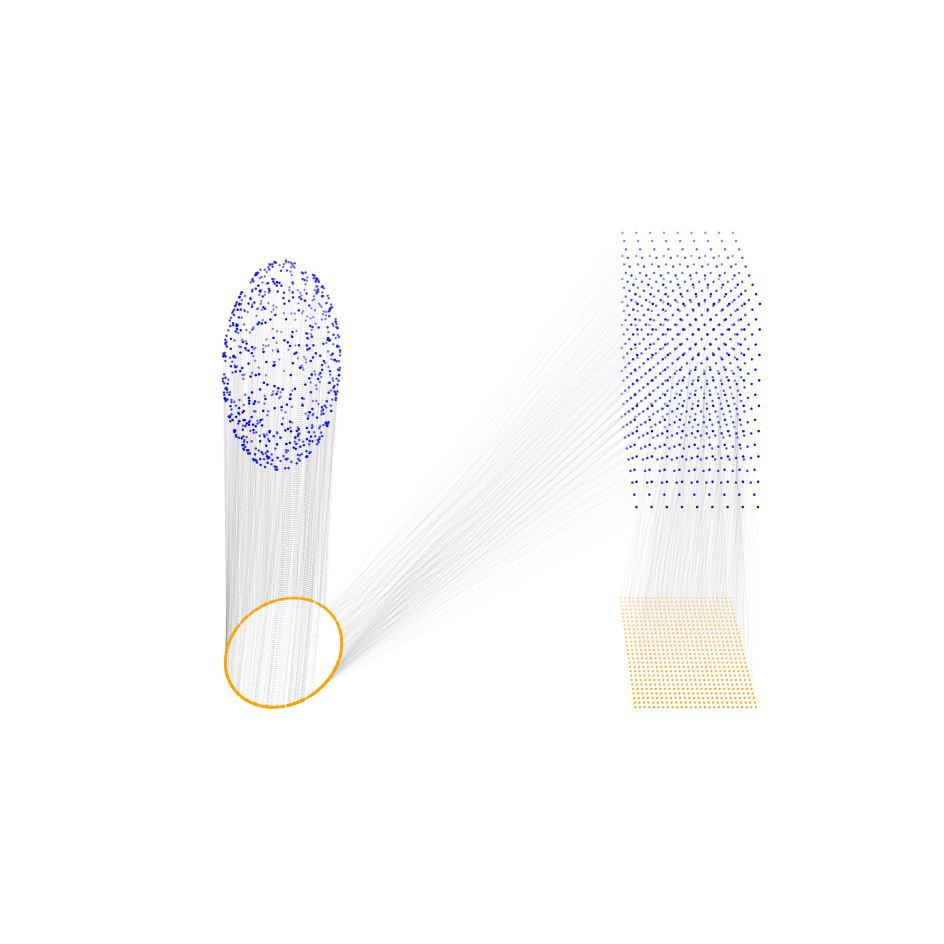

Gamma2


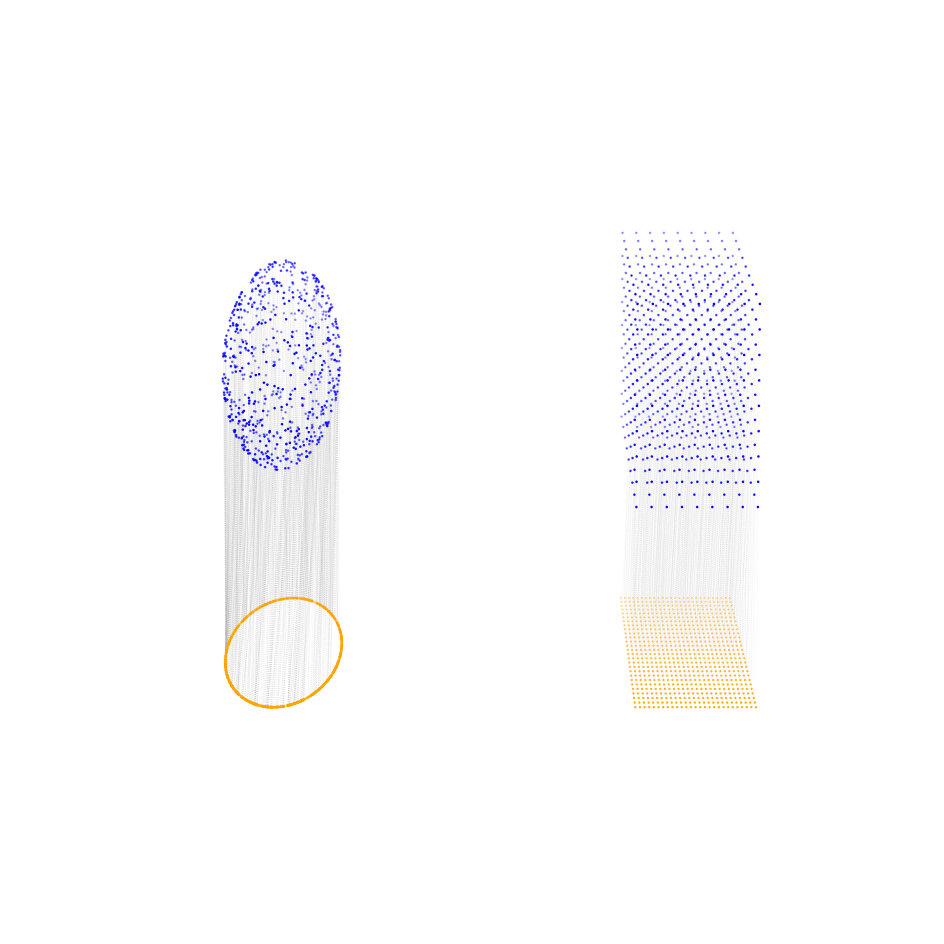

Gamma21


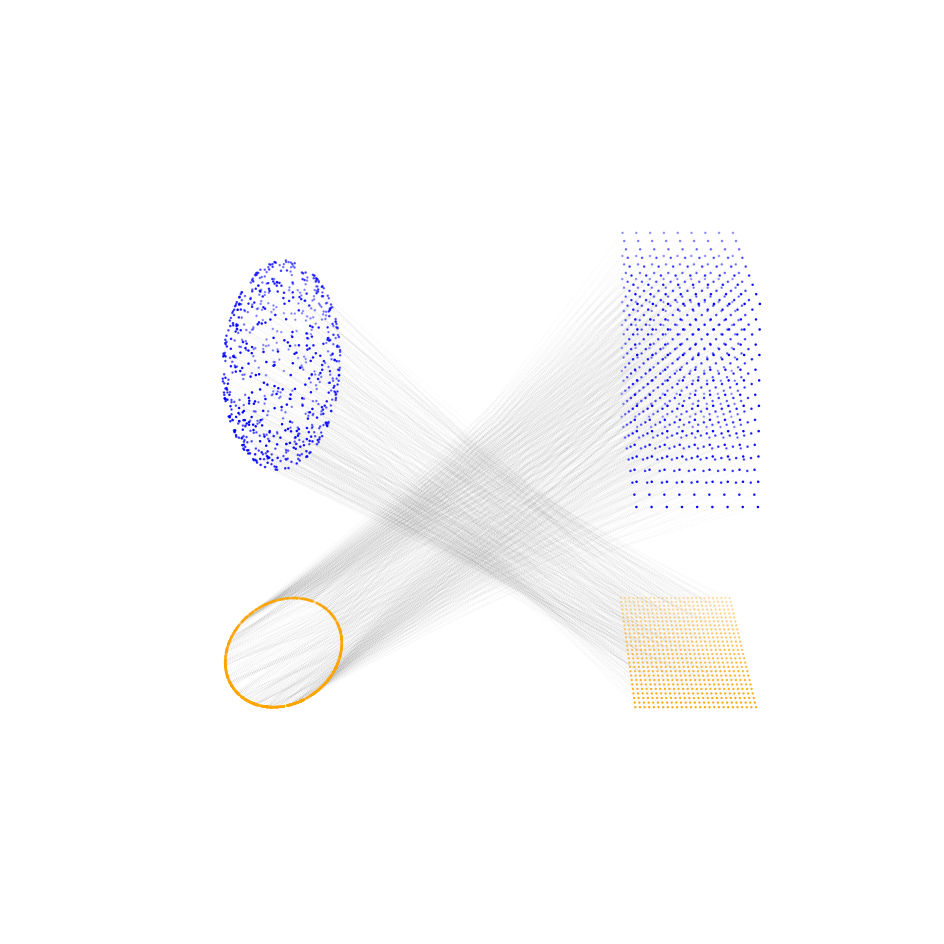

Gamma3


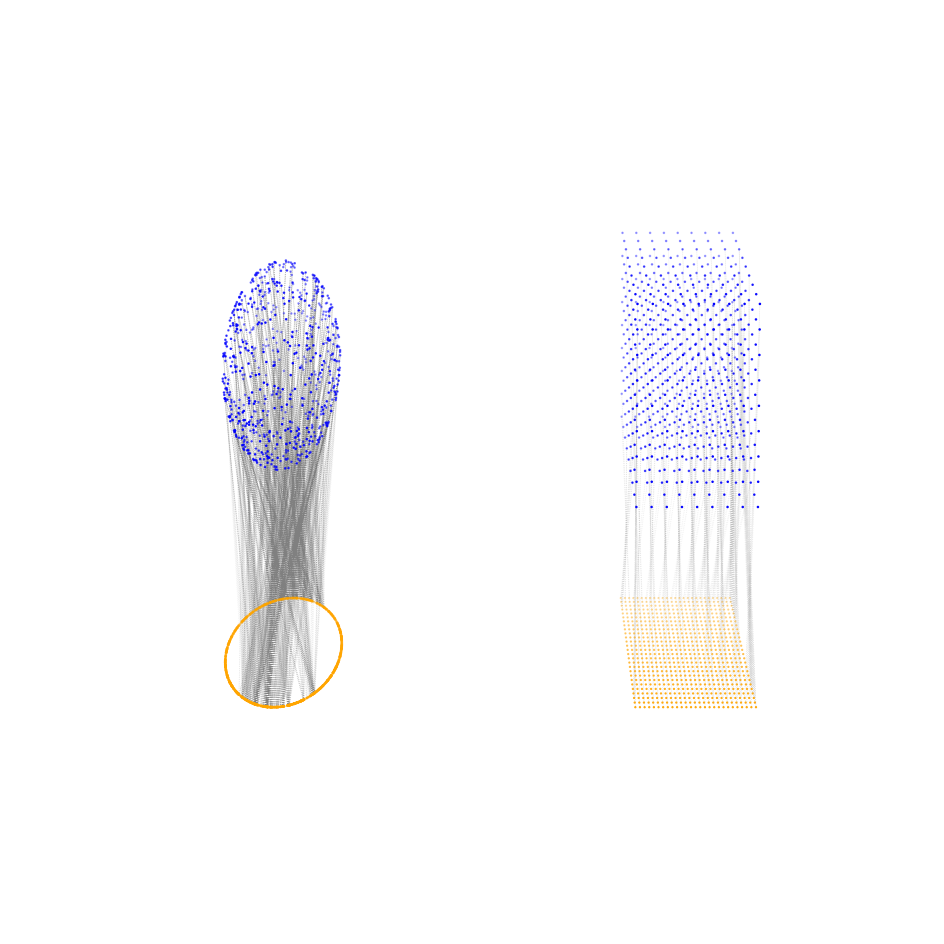

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def embed_3d(X):
    N,d=X.shape
    if d<3:
        X1=np.zeros((N,3))
        X1[:,0:d]=X
    else:
        X1=X.copy()
    return X1




def visual_plot(X,Y,p,q,gamma,eps=0.0004,save_name=None):
    X=embed_3d(X)
    Y=embed_3d(Y)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Adding legend
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('white') 
    
    # Plotting the scatter plot for shape X in orange
    scatter_X = ax.scatter(X[:,0], X[:,1], X[:,2], s=1000*p, color='orange', label='Shape X')

    # Plotting the scatter plot for shape Y in blue
    scatter_Y = ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=1000*q,color='blue', label='Shape Y')
    
    # show gamma:
    for (idx,x_point) in enumerate(X):
        for (idy,y_point) in enumerate(Y):
            if gamma[idx,idy]>eps:
                ax.plot([x_point[0], y_point[0]], [x_point[1], y_point[1]], [x_point[2], y_point[2]], linestyle=':', linewidth=0.5, alpha=0.1, color='grey')


        
    ax.view_init(10,90,0)
    if save_name is not None:
        plt.savefig('result/shape_matching/'+save_name+'.png',dpi=200,bbox_inches='tight', pad_inches=0)
    # Show plot
    plt.show()

print('Gamma1')
visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
print('Gamma2')
visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

print('Gamma21')
visual_plot(X,Y,p,q,gamma2_1,save_name='pr_pgw_3',eps=4e-4)


gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=2.1*1e-5)

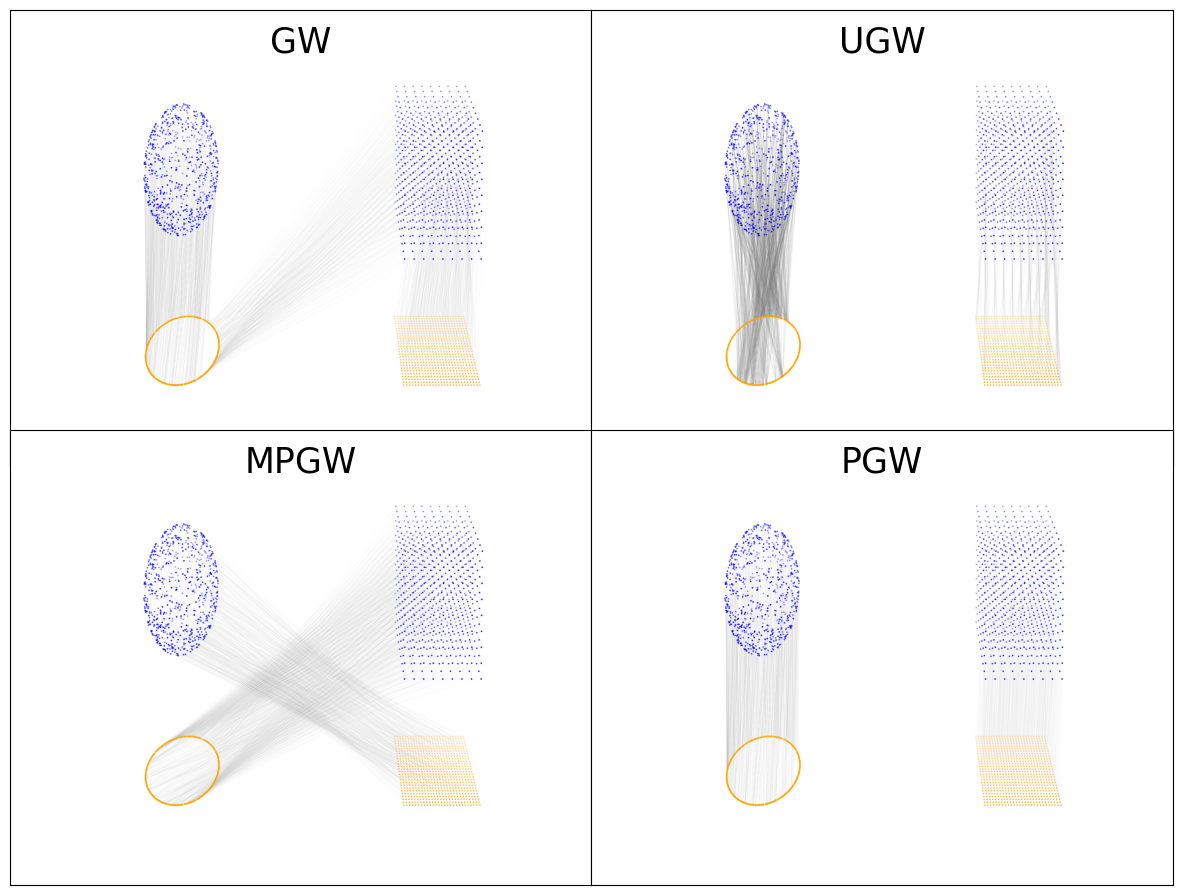

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
rows=2
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(3*5, 12*5))
# Remove the gaps between subplots

save_path='result/shape_matching/'
figure_list=['gw_3','ugw_3','pr_pgw_3','pgw_3']
for (i,(method,figure)) in enumerate(zip(['GW','UGW','MPGW','PGW'],figure_list)):
    i1,i2=np.divmod(i,2)
    #print('i1',i1)
    #print('i2',i2)
    path=save_path+figure+'.png'
    img = mpimg.imread(path)
    img_crop=img[200:-200,:,:]
    axs[i1,i2].imshow(img_crop)
    axs[i1,i2].set_xticks([])
    axs[i1,i2].set_yticks([])
#    axs[i1,i2].set_xlabel(method,fontsize=15)
    axs[i1,i2].set_title(method,fontsize=25,y=0.95, pad=-14)

plt.subplots_adjust(wspace=0, hspace=-0.9)

#plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.savefig('result/shape_matching/shape_wo.png',dpi=200, bbox_inches='tight', pad_inches=0)
plt.savefig('result/shape_matching/shape_wo.jpg',dpi=200, bbox_inches='tight', pad_inches=0)
plt.savefig('result/shape_matching/shape_wo.pdf',dpi=200, bbox_inches='tight', pad_inches=0)
# Display the figure
plt.show()

In [ ]:
# with prior knowledge
G0=np.ones(n)/n*3/5
time1=time.time()
gamma2,log1=gw.partial_gromov_v1(C1,C2,p,q,G0=G0,Lambda=300.0,numItermax=100*n,thres=1,tol=1e-5,log=False)
time2=time.time()

print('time of v1 is', time2-time1)


G0=np.ones(n)/n*3/5
#mass=0.8
G0=np.outer(p,q)/(np.sum(p)*np.sum(q))*mass
print('G0 mass is',G0.sum())
time1=time.time()
gamma2_1=partial_gromov_wasserstein(C1,C2,p,q, G0=G0,m=0.8,numItermax=1000*n,thres=1,tol=1e-5,log=False)
time2=time.time()
print('time of primal is', time2-time1)

C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
time1=time.time()
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=8.0, rho2=None,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
time2=time.time()
gamma3=gamma3T.numpy()
print('time of ugw is', time2-time1)

print('Gamma1')
visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
print('Gamma2')
visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

print('Gamma21')
visual_plot(X,Y,p,q,gamma2_1,save_name='pr_pgw_3',eps=4e-4)


gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=2.1*1e-5)

In [78]:
#@title Some preprocessing functions from Kaggle

import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
import pandas as pd
import random
import tqdm

def vector_to_voxel(vector, shape=(16,16,16)):
    vec_shape = list(vector.shape[:-1]) + list(shape)
    voxel = vector.reshape(*vec_shape)
    return voxel

def voxel_to_pointcloud(voxel, num_points=None, shuffle=True):
    assert len(voxel.shape)==3, f"Voxel should be a 3D tensor. Given shape {voxel.shape}!=3"
    x, y, z = np.nonzero(voxel)
    point_cloud = np.concatenate([np.expand_dims(x,axis=1), np.expand_dims(y,axis=1), np.expand_dims(z,axis=1)], axis=1)
    if num_points is not None:
        if point_cloud.shape[0] >= num_points:
            ids = list(range(point_cloud.shape[0]))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
        else:
            diff = num_points - len(point_cloud)
            padding = np.zeros([diff, 3])
            point_cloud = np.concatenate([point_cloud, padding], axis=0)
            ids = list(range(len(point_cloud)))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
    return point_cloud


def vector_to_pointcloud(vector, num_points=None, shuffle=True):
    voxel = vector_to_voxel(vector)
    voxel = np.squeeze(voxel)
    point_cloud = voxel_to_pointcloud(voxel, num_points, shuffle)
    return point_cloud

In [79]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra

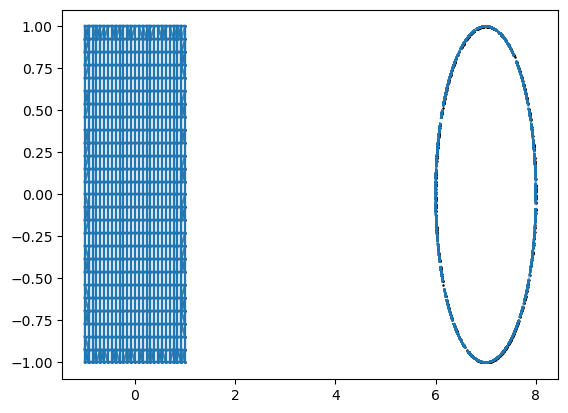

In [80]:


pc=X.copy()
D_euc=np.sqrt(((pc[np.newaxis,:,:2]-pc[:,np.newaxis,:2])**2).sum(-1))

knnG = kneighbors_graph(pc[:,:2], n_neighbors=4,mode='distance')
D_graph = dijkstra(knnG,directed=False)
C1=D_graph.copy()
# Just for visualization
plt.scatter(pc[:,0], pc[:,1],c='k',s=0.6)
for i in knnG.indices:
  for j in knnG[i].indices:
    plt.plot([pc[i,0], pc[j,0]], [pc[i,1],pc[j,1]],c='C0',alpha=.5)
plt.show()


A=C1>100
C1[A]=100



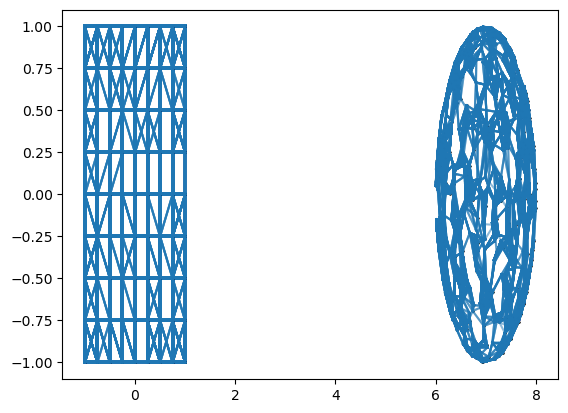

In [81]:
pc=Y.copy()
D_euc=np.sqrt(((pc[np.newaxis,:,:3]-pc[:,np.newaxis,:3])**2).sum(-1))

knnG = kneighbors_graph(pc[:,:3], n_neighbors=6,mode='distance')
D_graph = dijkstra(knnG,directed=False)
C2=D_graph.copy()
#C[D_graph>=100]=100
# Just for visualization
plt.scatter(pc[:,0], pc[:,1],c='k',s=0.6)
for i in knnG.indices:
  for j in knnG[i].indices:
    plt.plot([pc[i,0], pc[j,0]], [pc[i,1],pc[j,1]],c='C0',alpha=.5)
plt.show()



B=C2>100
C2[B]=200

In [82]:
# gamma1=ot.gromov.gromov_wasserstein(C1,C2,p,q,tol=1e-5)
# gamma2,log1=partial_gromov_v1(C1,C2,p,q,Lambda=20.0,numItermax=100000,tol=1e-5,log=False)
# print(gamma2.sum())
C1_T=torch.from_numpy(C1).to(torch.float32)
C2_T=torch.from_numpy(C1).to(torch.float32)
p_T=torch.from_numpy(p).to(torch.float32)
q_T=torch.from_numpy(q).to(torch.float32)
gamma3T,_=log_ugw_sinkhorn(a=p_T, dx=C1_T, b=q_T, dy=C2_T, init=None, eps=eps,
                             rho=30.0, rho2=30.0,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
gamma3=gamma3T.numpy()
print('G3 is',gamma3.sum())

G3 is 0.30150732


Gamma3


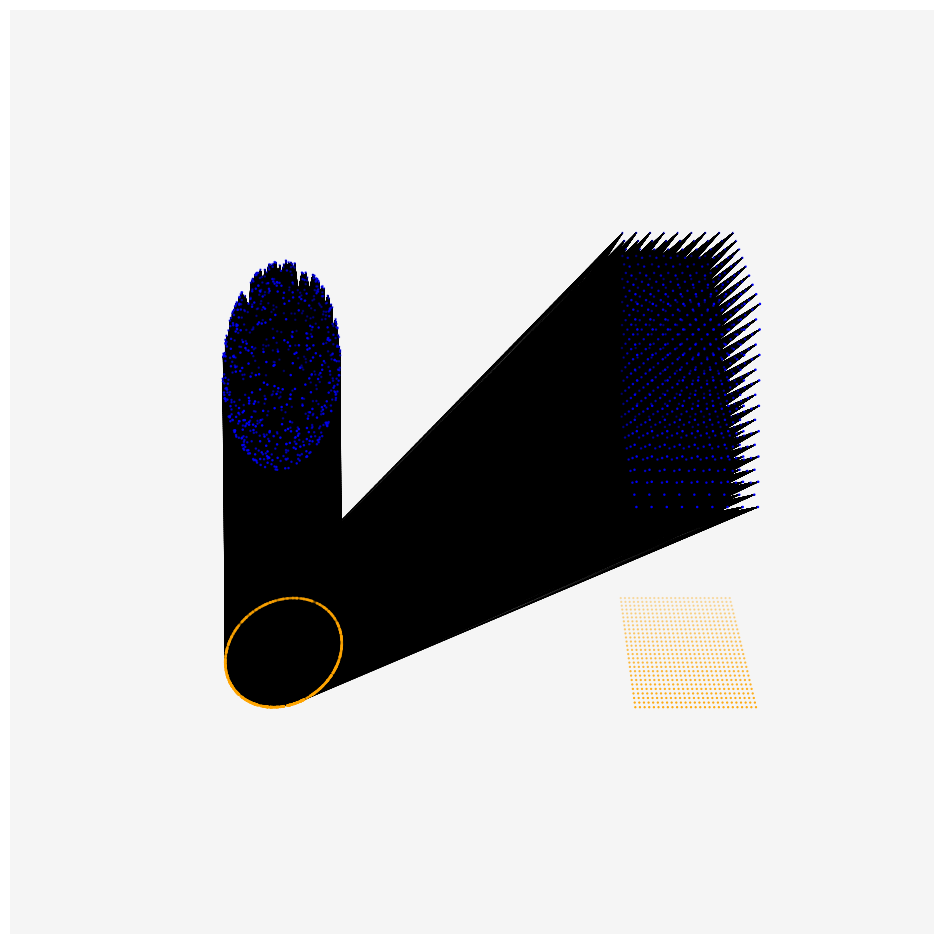

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def embed_3d(X):
    N,d=X.shape
    if d<3:
        X1=np.zeros((N,3))
        X1[:,0:d]=X
    else:
        X1=X.copy()
    return X1




def visual_plot(X,Y,p,q,gamma,eps=0.0004,save_name=None):
    X=embed_3d(X)
    Y=embed_3d(Y)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # Adding legend
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')
    ax.set_facecolor('whitesmoke') 
    
    # Plotting the scatter plot for shape X in orange
    scatter_X = ax.scatter(X[:,0], X[:,1], X[:,2], s=1000*p, color='orange', label='Shape X')

    # Plotting the scatter plot for shape Y in blue
    scatter_Y = ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=1000*q,color='blue', label='Shape Y')
    
    # show gamma:
    for (idx,x_point) in enumerate(X):
        for (idy,y_point) in enumerate(Y):
            if gamma[idx,idy]>eps:
                ax.plot([x_point[0], y_point[0]], [x_point[1], y_point[1]], [x_point[2], y_point[2]], linestyle=':', linewidth=0.5, alpha=0.3, color='black')


        
    ax.view_init(10,90,0)
    if save_name is not None:
        plt.savefig('result/shape_matching/'+save_name+'.png',dpi=200,bbox_inches='tight', pad_inches=0)
    # Show plot
    plt.show()

# print('Gamma1')
# visual_plot(X,Y,p,q,gamma1,save_name='gw_3',eps=4e-4)
# print('Gamma2')
# visual_plot(X,Y,p,q,gamma2,save_name='pgw_3',eps=4e-4)

gamma3=gamma3T.numpy().astype(np.float64)
print('Gamma3')
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=4.0e-8)

In [ ]:
visual_plot(X,Y,p,q,gamma3,save_name='ugw_3',eps=4.9e-8)